In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Enable multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()  # Automatically uses available GPUs
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

with strategy.scope():
    # Load and preprocess MNIST dataset
    (train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()
    
    # Normalize the data
    all_data = np.concatenate((train_data, test_data), axis=0).astype("float32") / 255.0
    all_labels = np.concatenate((train_labels, test_labels), axis=0)
    
    # Expand dimensions for compatibility with DenseNet and ResNet (add channel dimension)
    all_data = np.expand_dims(all_data, axis=-1)
    all_data = np.tile(all_data, (1, 1, 1, 3))  # Convert to 3 channels
    
    # Resize images to 64x64 for DenseNet121 and ResNet50
    all_data_resized = np.array([tf.image.resize(image, (64, 64)).numpy() for image in all_data])
    
    # Split into train, validation, and test sets
    data_train, data_temp, labels_train, labels_temp = train_test_split(
        all_data_resized, all_labels, test_size=0.4, random_state=42
    )
    data_val, data_test, labels_val, labels_test = train_test_split(
        data_temp, labels_temp, test_size=0.5, random_state=42
    )

Number of GPUs: 2
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
resnet_model = Sequential()
densenet_model = Sequential()

densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3),pooling='max',classes=10)
resnet_base = ResNet50(weights='imagenet',include_top=False, input_shape=(64, 64, 3),pooling='max',classes=10)

for layer in resnet_base.layers:
    layer.trainable = False

resnet_model.add(resnet_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(128,activation='relu'))
resnet_model.add(Dense(10,activation='softmax'))

densenet_model.add(resnet_base)
densenet_model.add(Flatten())
densenet_model.add(Dense(512,activation='relu'))
densenet_model.add(Dense(512,activation='relu'))
densenet_model.add(Dense(128,activation='relu'))
densenet_model.add(Dense(10,activation='softmax'))

resnet_model.compile(optimizer=Adam(learning_rate=0.0005), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
densenet_model.compile(optimizer=Adam(learning_rate=0.0005), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])


In [18]:
history = resnet_model.fit(
        data_train, labels_train,
        validation_data=(data_val,labels_val),
        epochs=60,
        batch_size=1024
    )

Epoch 1/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 446ms/step - accuracy: 0.5144 - loss: 1.6618 - val_accuracy: 0.7752 - val_loss: 0.6835
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.8343 - loss: 0.5424 - val_accuracy: 0.8694 - val_loss: 0.4148
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.8938 - loss: 0.3624 - val_accuracy: 0.8923 - val_loss: 0.3457
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.9093 - loss: 0.2924 - val_accuracy: 0.9052 - val_loss: 0.3069
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step - accuracy: 0.9167 - loss: 0.2570 - val_accuracy: 0.9305 - val_loss: 0.2282
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 295ms/step - accuracy: 0.9360 - loss: 0.2085 - val_accuracy: 0.9344 - val_loss: 0.2125
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 305ms/step - accuracy: 0.9412 - loss: 0.1940 - val_accuracy: 0.9234 - val_loss: 0.2364
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 304ms/step - accuracy: 0.9403 - loss: 0.1842 - val_accu

438/438 - 7s - 17ms/step - accuracy: 0.9647 - loss: 0.1126
Resnet Test Accuracy: 96.47%


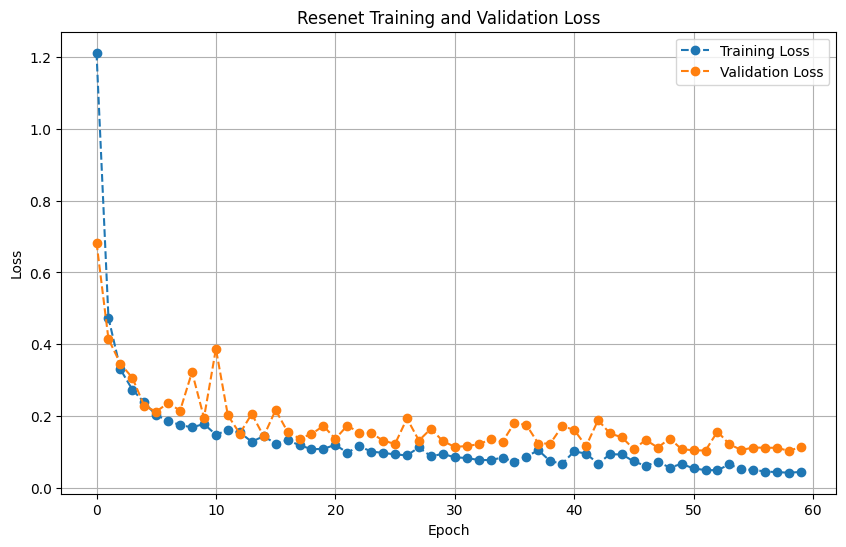

In [19]:
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(data_test, labels_test, verbose=2)
print(f"Resnet Test Accuracy: {resnet_test_accuracy * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title(f'Resenet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
history_d = densenet_model.fit(
        data_train, labels_train,
        validation_data=(data_val,labels_val),
        epochs=60,
        batch_size=1024
    )

Epoch 1/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - accuracy: 0.4774 - loss: 1.7109 - val_accuracy: 0.8028 - val_loss: 0.6508
Epoch 2/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - accuracy: 0.8323 - loss: 0.5584 - val_accuracy: 0.8215 - val_loss: 0.5342
Epoch 3/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - accuracy: 0.8685 - loss: 0.4099 - val_accuracy: 0.9149 - val_loss: 0.3029
Epoch 4/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - accuracy: 0.9175 - loss: 0.2745 - val_accuracy: 0.9063 - val_loss: 0.2874
Epoch 5/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 309ms/step - accuracy: 0.9195 - loss: 0.2659 - val_accuracy: 0.9284 - val_loss: 0.2325
Epoch 6/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - accuracy: 0.9334 - loss: 0.2155 - val_accuracy: 0.9377 - val_loss: 0.2006
Epoch 7/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - accuracy: 0.9421 - loss: 0.1881 - val_accuracy: 0.9164 - val_loss: 0.2473
Epoch 8/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - accuracy: 0.9361 - loss: 0.2013 - val_accu

438/438 - 7s - 17ms/step - accuracy: 0.9676 - loss: 0.1052
Densenet Test Accuracy: 96.76%


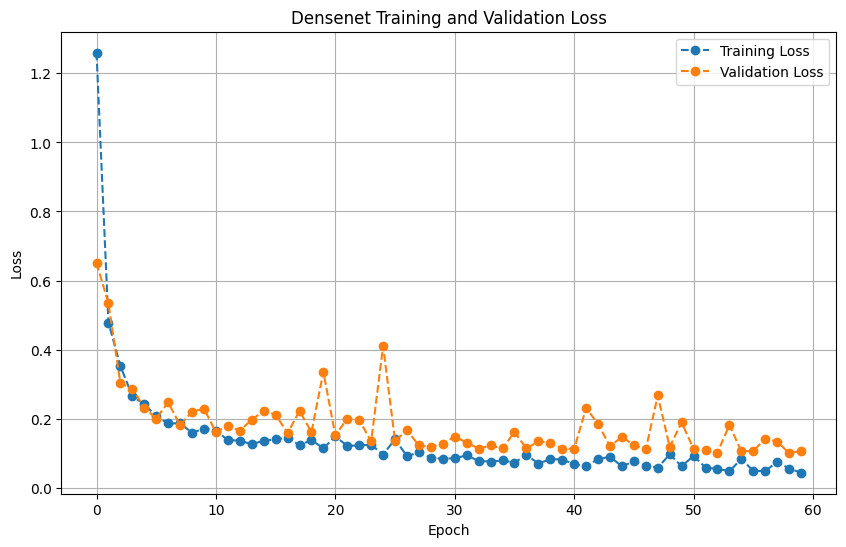

In [22]:
densenet_test_loss, densenet_test_accuracy = densenet_model.evaluate(data_test, labels_test, verbose=2)
print(f"Densenet Test Accuracy: {densenet_test_accuracy * 100:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(history_d.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history_d.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title(f'Densenet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()